<a href="https://colab.research.google.com/github/KamonohashiPerry/MachineLearning/blob/master/PSI_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reference
https://github.com/mwburke/population-stability-index/blob/master/walkthrough-example.ipynb

In [0]:
import numpy as np

def calculate_psi(expected,
                  actual,
                  buckettype='bins',
                  buckets=10,
                  axis=0):
  '''Calculate the PSI (population stability index) across all variables
        Args:
        expected: numpy matrix of original values
        actual: numpy matrix of new values, same size as expected
        buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
        buckets: number of quantiles to use in bucketing variables
        axis: axis by which variables are defined, 0 for vertical, 1 for horizontal
      Returns:
        psi_values: ndarray of psi values for each variable
      Author:
        Matthew Burke
        github.com/mwburke
        worksofchart.com
  '''
  def psi(expected_array,
          actual_array,
          buckets):
    '''Calculate the PSI for a single variable
        Args:
            expected_array: numpy array of original values
            actual_array: numpy array of new values, same size as expected
            buckets: number of percentile ranges to bucket the values into
        Returns:
            psi_value: calculated PSI value
    '''

    # 最小値、最大値が所与のもとで、inputの最小値でinputを引き、inputの最大値を所与の最小・最大の差で割り、所与の最小値を足す。
    def scale_range(input, min, max):
      input += -(np.min(input)) # 代入演算子 a = a + b に同じ
      input /= np.max(input) / (max - min) # 代入演算子 a = a / b に同じ
      input += min 
      return input

    # これはなにをしている？
    breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

    # 階級値の場合
    if buckettype == 'bins':
      breakpoints = scale_range(input=breakpoints,
                                 min=np.min(expected_array),
                                 max=np.max(expected_array))
    # 実数の場合
    elif buckettype == 'quantities':
      breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints ])

    # 
    expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
    actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

    # 実際の値と期待値が0かどうか考慮した上で、商の対数に差分をかけたものを返す。
    def sub_psi(e_perc, a_perc):
      '''Calculate the actual PSI value from comparing the values.
          Update the actual value to a very small number if equal to zero
      '''
      # actual
      if a_perc == 0:
        a_perc = 0.001
      # expected
      if e_perc == 0:
        e_perc == 0.001

      value = (e_perc - a_perc) * np.log(e_perc / a_perc)
      return value

    # 
    psi_value = sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

    return psi_value

  if len(expected.shape) == 1:
    psi_values = np.empty(len(expected.shape))

  else:
    psi_values = np.empty(expected.shape[axis])
  
  for i in range(0, len(psi_values)):
    if len(psi_values) == 1:
      psi_values = psi(expected, actual, buckets)
    elif axis == 0:
      psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
    elif axis == 1:
      psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

  return psi_values


## PSI Walkthrough

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
sns.set_style("white")
rs = np.random.RandomState(5)

initial = rs.normal(size = 100)
new = rs.normal(loc = 0.2, size = 120)

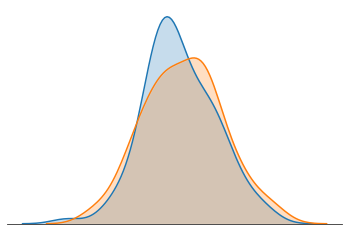

In [0]:
plot = sns.kdeplot(initial, shade=True)
plot = sns.kdeplot(new, shade=True)
plot.set(yticklabels=[], xticklabels = [])
sns.despine(left=True)

In [0]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

In [0]:
buckets = 10
raw_breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

In [0]:
raw_breakpoints

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [0]:
breakpoints = scale_range(raw_breakpoints, np.min(initial), np.max(initial))

In [0]:
breakpoints = scale_range(raw_breakpoints, np.min(initial), np.max(initial))

In [0]:
breakpoints

array([-2.85968797, -2.33064205, -1.80159614, -1.27255022, -0.74350431,
       -0.21445839,  0.31458753,  0.84363344,  1.37267936,  1.90172527,
        2.43077119])

In [0]:
initial_counts = np.histogram(initial, breakpoints)[0]
new_counts = np.histogram(new, breakpoints)[0]

In [0]:
initial_counts

array([ 1,  1,  4,  8, 27, 22, 16, 12,  6,  2])

In [0]:
new_counts

array([ 0,  3,  6, 15, 18, 23, 26, 14,  9,  3])

In [0]:
df = pd.DataFrame({'Bucket': np.arange(1, 11),
                     'Breakpoint Value':breakpoints[1:],
                     'Initial Count':initial_counts,
                     'New Count':new_counts})

df['Initial Percent'] = df['Initial Count'] / len(initial)
df['New Percent'] = df['New Count'] / len(new)

In [0]:
df['New Percent'][df['New Percent'] == 0] = 0.001

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df

,Bucket,Breakpoint Value,Initial Count,New Count,Initial Percent,New Percent
0,1,-2.330642,1,0,0.01,0.001000
1,2,-1.801596,1,3,0.01,0.025000
2,3,-1.272550,4,6,0.04,0.050000
3,4,-0.743504,8,15,0.08,0.125000
4,5,-0.214458,27,18,0.27,0.150000
5,6,0.314588,22,23,0.22,0.191667
6,7,0.843633,16,26,0.16,0.216667
7,8,1.372679,12,14,0.12,0.116667
8,9,1.901725,6,9,0.06,0.075000
9,10,2.430771,2,3,0.02,0.025000


In [0]:
percents = df[['Initial Percent', 'New Percent', 'Bucket']] \
             .melt(id_vars=['Bucket']) \
             .rename(columns={'variable':'Population', 'value':'Percent'})

In [0]:
percents.head()

,Bucket,Population,Percent
0,1,Initial Percent,0.01
1,2,Initial Percent,0.01
2,3,Initial Percent,0.04
3,4,Initial Percent,0.08
4,5,Initial Percent,0.27


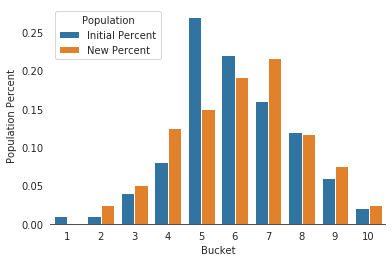

In [0]:
p = sns.barplot(x="Bucket",
                y="Percent",
                hue="Population",
                data=percents)

p.set(xlabel='Bucket', ylabel='Population Percent')
sns.despine(left=True)

PSIは比較対象の%の差分にその商の対数をかけあわせたものの和

In [0]:
df['PSI'] = (df['New Percent'] - df['Initial Percent']) * np.log(df['New Percent'] / df['Initial Percent'])

In [0]:
df.head()

,Bucket,Breakpoint Value,Initial Count,New Count,Initial Percent,New Percent,PSI
0,1,-2.330642,1,0,0.01,0.001,0.020723
1,2,-1.801596,1,3,0.01,0.025,0.013744
2,3,-1.272550,4,6,0.04,0.050,0.002231
3,4,-0.743504,8,15,0.08,0.125,0.020083
4,5,-0.214458,27,18,0.27,0.150,0.070534


In [0]:
# これがPSI
np.sum(df['PSI'])

0.15296002119653457

In [65]:
np.round(np.sum(df['PSI']), 5)

0.15296

In [63]:
np.round(calculate_psi(initial, new, buckets=10, axis=1), 3) == np.round(np.sum(df['PSI']), 3)

True

In [64]:
calculate_psi(initial, new, buckets=10, axis=1)

0.15275591122393328

In [0]:
breakpoints = np.stack([np.percentile(initial, b) for b in np.arange(0, buckets + 1) / (buckets) * 100])

In [0]:
initial_counts = np.histogram(initial, breakpoints)[0]
new_counts = np.histogram(new, breakpoints)[0]

In [75]:
df = pd.DataFrame({'Bucket': np.arange(1, 11), 'Breakpoint Value':breakpoints[1:], 'Initial Count':initial_counts, 'New Count':new_counts})
df['Initial Percent'] = df['Initial Count'] / len(initial)
df['New Percent'] = df['New Count'] / len(new)
df['New Percent'][df['New Percent'] == 0] = 0.001
percents = df[['Initial Percent', 'New Percent', 'Bucket']] \
             .melt(id_vars=['Bucket']) \
             .rename(columns={'variable':'Population', 'value':'Percent'})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


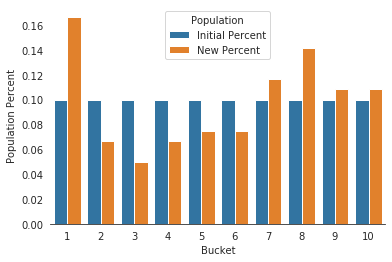

In [76]:
p = sns.barplot(x="Bucket", y="Percent", hue="Population", data=percents)
p.set(xlabel='Bucket', ylabel='Population Percent')
sns.despine(left=True)

In [77]:
calculate_psi(initial, new, buckettype='quantiles', buckets=10, axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in log


inf